# CIS6800: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 18 at 11:59 p.m.
* Part (b) Oct. 23 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train.

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
try:
    import dataset
    import model
    import train
    import inference
except ModuleNotFoundError:
    pass

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this. You can find the dataset set here: https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [ ]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path="/content/drive/MyDrive/CIS680/hw3/data/"

In [3]:
!pip install h5py
import numpy as np
import h5py
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
f=h5py.File(path+"/hw3_mycocodata_mask_comp_zlib.h5")
mask=f['data']
f=h5py.File(path+"/hw3_mycocodata_img_comp_zlib.h5")
image=f['data']
bboxes=np.load(path+"/hw3_mycocodata_bboxes_comp_zlib.npy",allow_pickle=True)
labels=np.load(path+"/hw3_mycocodata_labels_comp_zlib.npy",allow_pickle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
count=0
gt_mask_indices=[]
for number in labels:
  mask_list=[]
  for each_count in range(len(number)):
    mask_list.append(count)
    count=count+1
  gt_mask_indices.append(mask_list)

In [6]:
gt_mask_list=[]
for mask_indices in gt_mask_indices:
  gt_mask_list.append(mask[mask_indices])

In [7]:
subset_images=image
subset_masks=gt_mask_list
subset_bounding_boxes=bboxes
subset_labels=labels

In [8]:
from torchvision import transforms
img_vis_transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229,0.224,0.225)),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
mask_transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
import torch
from torch.utils.data import Dataset
class SOLO_Dataset(Dataset):
  def __init__(self, bbox_list,gt_mask_list,image,label_list,transform=None):

          self.bbox_list = bbox_list
          self.gt_mask_list=gt_mask_list
          self.transform = transform
          self.images=image
          self.labels=label_list
          self.transform=transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      image=self.images[idx]
      bbox=self.bbox_list[idx]
      label=self.labels[idx]
      masks=self.gt_mask_list[idx]

      if self.transform:
        scale_y=800.0/300.0
        scale_x=1066.0/400.0  
        transformed_image=img_vis_transform((image/255).astype(np.float32).transpose(1,2,0))
        scaled_bbox=np.zeros_like(bbox)
        scaled_bbox[:,0]=bbox[:,0]*scale_x+11
        scaled_bbox[:,1]=bbox[:,1]*scale_y
        scaled_bbox[:,2]=bbox[:,2]*scale_x+11
        scaled_bbox[:,3]=bbox[:,3]*scale_y
        transformed_masks=mask_transforms(masks.astype(np.float32).transpose(1,2,0))
        return transformed_image,scaled_bbox,transformed_masks,label
      
      return image,bbox,masks,label



In [9]:
from torchvision import transforms
img_vis_transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
mask_transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((800,1066)),transforms.Pad(padding=(11,0), fill=0, padding_mode='constant')])
import torch
from torch.utils.data import Dataset
class SOLO_Dataset_vis(Dataset):
  def __init__(self, bbox_list,gt_mask_list,image,label_list,transform=None):

          self.bbox_list = bbox_list
          self.gt_mask_list=gt_mask_list
          self.transform = transform
          self.images=image
          self.labels=label_list
          self.transform=transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      image=self.images[idx]
      bbox=self.bbox_list[idx]
      label=self.labels[idx]
      masks=self.gt_mask_list[idx]

      if self.transform:
        scale_y=800.0/300.0
        scale_x=1066.0/400.0  
        transformed_image=img_vis_transform(image.astype(np.int32).transpose(1,2,0))
        scaled_bbox=np.zeros_like(bbox)
        scaled_bbox[:,0]=bbox[:,0]*scale_x+11
        scaled_bbox[:,1]=bbox[:,1]*scale_y
        scaled_bbox[:,2]=bbox[:,2]*scale_x+11
        scaled_bbox[:,3]=bbox[:,3]*scale_y
        transformed_masks=mask_transforms(masks.astype(np.int32).transpose(1,2,0))
        return transformed_image,scaled_bbox,transformed_masks,label
      
      return image,bbox,masks,label


In [10]:
my_dataset=SOLO_Dataset(subset_bounding_boxes,subset_masks,subset_images,subset_labels,transform=True)
my_dataset_vis=SOLO_Dataset_vis(subset_bounding_boxes,subset_masks,subset_images,subset_labels,transform=True)

In [ ]:
print(torch.where((my_dataset[0][0][0])>1))
print(my_dataset[0][0][0][0, 242])

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
tensor(0.2560)


In [ ]:
# print(my_dataset[0][1].shape)
from matplotlib import pyplot as plt
im, bb, m , l = my_dataset[0]
arr = im.detach().cpu().numpy()
print(np.mean(arr))
# arr = arr.astype(np.int)
# print(np.where((arr<0)))
# plt.imshow(arr)

0.32375616


In [ ]:
def visualise_new(image,mask,labels):
  from copy import deepcopy
  img=deepcopy(image.transpose(1,2,0))

  assert(len(mask)==len(labels))

  
  mask_img_green_person=np.sum(mask[labels==1],axis=0)%2
  mask_img_red_animal=np.sum(mask[labels==3],axis=0)%2
  mask_img_blue_vehicle=np.sum(mask[labels==2],axis=0)%2


  img_red_channel=mask_img_red_animal*(0.5*img[:,:,0]+0.5*255*mask_img_red_animal)
  img[:,:,0]=img_red_channel + (1-mask_img_red_animal)*img[:,:,0] 
  
  img_green_channel=mask_img_green_person*(0.5*img[:,:,1]+0.5*255*mask_img_green_person)
  img[:,:,1]=img_green_channel + (1-mask_img_green_person)*img[:,:,1] 

  img_blue_channel=mask_img_blue_vehicle*(0.5*img[:,:,2]+0.5*255*mask_img_blue_vehicle)
  img[:,:,2]=img_blue_channel + (1-mask_img_blue_vehicle)*img[:,:,2] 
  
  
  return img

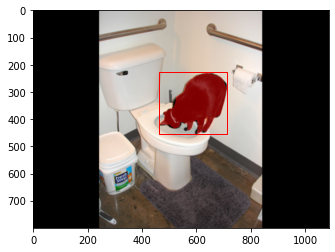

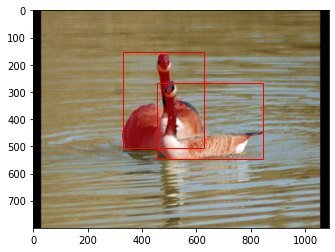

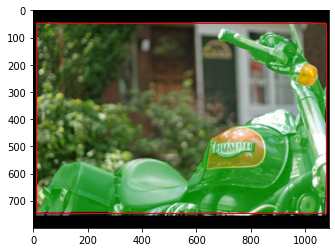

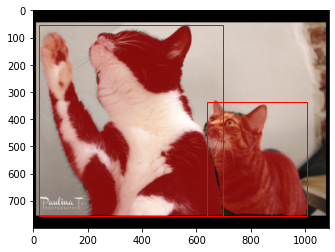

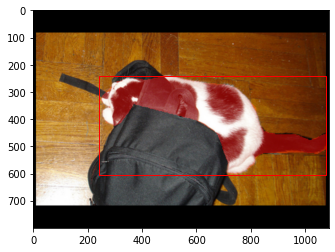

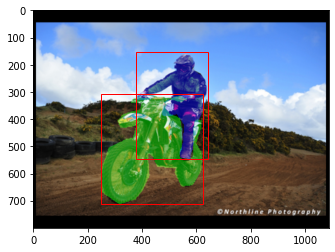

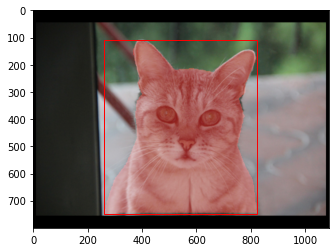

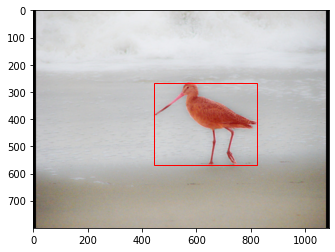

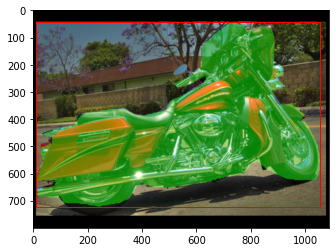

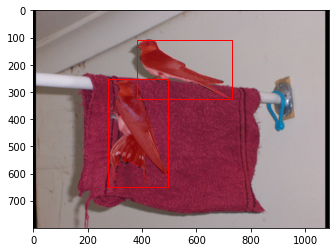

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
for i in range(len(my_dataset)):
  img=visualise_new(my_dataset[i][0].numpy(),my_dataset[i][2].numpy(),my_dataset[i][3])
  plt.imshow(img)
  for bbox in my_dataset[i][1]:
    xa=int(bbox[0])
    ya=int(bbox[1])
    xb=int(bbox[2])
    yb=int(bbox[3])
    w=xb-xa
    h=yb-ya
   
    plt.gca().add_patch(Rectangle((xa,ya),w,h,
                    edgecolor='red',
                    facecolor='none',
                    ))
  plt.show()

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/CIS680/hw3/data/"
img_file = path + 'hw3_mycocodata_img_comp_zlib.h5'
mask_file = path +'hw3_mycocodata_mask_comp_zlib.h5'
label_file =path +'hw3_mycocodata_labels_comp_zlib.npy'
bbox_file = path +'hw3_mycocodata_bboxes_comp_zlib.npy'
import h5py
import numpy as np
from copy import deepcopy
file_img = h5py.File(img_file, 'r')
img_data = file_img['data']
file = h5py.File(mask_file, 'r')
mask_data = file['data']
label_data = deepcopy(np.load(label_file,allow_pickle=True))
bbox_data = deepcopy(np.load(bbox_file,allow_pickle=True))
mask_ct = 0
mask_data_per_img = []
for j in range(img_data.shape[0]):
  img_index = j
  len_labels = label_data[img_index].shape[0]
  mask_img = mask_data[mask_ct:mask_ct+len_labels]
  mask_ct +=len_labels
  mask_data_per_img.append(mask_img)

print(np.array(bbox_data)[1])
import torch
from torch.utils.data import Dataset
from torchvision import transforms
# img_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((800,1066)), transforms.Pad((11,0), fill=0, padding_mode='constant'), 
#                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
img_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((800,1066)), transforms.Pad((11,0), fill=0, padding_mode='constant')])
mask_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((800,1066)), transforms.Pad((11,0), fill=0, padding_mode='constant')])
class dataset(Dataset):
  def __init__(self, images, labels, masks, bbox, transform=None):
    self.images = images
    self.labels = labels
    self.masks = masks
    self.bbox = bbox
    self.transform = transform

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    img_int = img_transform(self.images[index].astype(np.int32).transpose(1,2,0))
    mask_int = mask_transform(self.masks[index].astype(np.int32).transpose(1,2,0))
    bbox_int = self.bbox[index]
    label_int = self.labels[index]
    scale_y=800.0/300.0
    scale_x=1066.0/400.0 
    bbox_int[:,0] = bbox_int[:,0]*scale_x +11
    bbox_int[:,2] = bbox_int[:,2]*scale_x +11
    bbox_int[:,1] = bbox_int[:,1]*scale_y
    bbox_int[:,3] = bbox_int[:,3]*scale_y



    return img_int, mask_int, bbox_int, label_int

from  copy import deepcopy
data = dataset(img_data, deepcopy(label_data), mask_data_per_img, deepcopy(bbox_data))


[[167.       100.16265  312.80722  204.6747  ]
 [119.421684  57.391567 232.48193  190.36748 ]]


In [3]:
# This function build the ground truth tensor for each batch in the training
# Input:
#     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
#     labels:           list, len(batch_size), each (n_object, )
#     masks:            list, len(batch_size), each (n_object, 800, 1088)
# Output:
#     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
#     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
#     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
#     / boolean array with positive mask predictions

scale_r = [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)]
strides = [8, 8, 16, 32, 32]
epsilon = 0.2
num_grids =[40, 36, 24, 16, 12]
from copy import deepcopy
from matplotlib import pyplot as plt
import torch.nn.functional as F
def generate_targets(images, bounding_boxes, labels, masks):

  # i, m,b,l = dataset(img_data, deepcopy(label_data), mask_data_per_img, deepcopy(bbox_data))[1]
  # print(b)
  # plt.imshow(i.cpu().detach().numpy().transpose(1,2,0))

  num_imgs = len(images)
  # print(num_imgs)
  cat_tgts = [[] for kk in range(num_imgs)]
  mask_tgts = [[] for kk in range(num_imgs)]
  active_tgts = [[] for kk in range(num_imgs)]
  img_appended = []
  for n in range(num_imgs): #for each image
    pyr_appended_cat = []
    pyr_appended_mask = []
    pyr_appended_active = []
    # from copy import deepcopy
    # print(masks[n])
    img_imp,mask_imp, bbox_imp , label_imp= dataset(images, deepcopy(labels), masks, deepcopy(bounding_boxes))[n]
    # print(bbox_imp)
    plt.imshow(img_imp.cpu().detach().numpy().transpose(1,2,0))
    bbox_imp = torch.from_numpy(bbox_imp)
    label_imp = torch.from_numpy(label_imp)
    area = torch.sqrt((bbox_imp[:,2] - bbox_imp[:,0])*(bbox_imp[:,3] - bbox_imp[:,1]))
    # print(area)
    img_appended.append(img_imp)
    #scaling bbox to find the central box!!!
    w_sbox = (bbox_imp[:,2] - bbox_imp[:,0])*epsilon
    h_sbox = (bbox_imp[:,3] - bbox_imp[:,1])*epsilon
    c_x = (bbox_imp[:,2] + bbox_imp[:,0])/2
    c_y = (bbox_imp[:,3] + bbox_imp[:,1])/2
    new_upedges_x = c_x + w_sbox/2 #these will be used to check the grids for the object detection
    new_lowedges_x = c_x - w_sbox/2
    new_upedges_y = c_y + h_sbox/2
    new_lowedges_y = c_y - h_sbox/2
    h = 800.0
    w = 1088.0

    #now going for the pyramid output
    for j in range(5):
      #checking to see if the area is under the scale range or not
      cat_branch = torch.zeros((num_grids[j], num_grids[j])) #4 channels for 4 outputs
      mask_branch = torch.zeros((num_grids[j]*num_grids[j], int(2*h/strides[j]), int(2*w/strides[j])))
      active_branch = torch.zeros((num_grids[j]*num_grids[j]))
      scale_py = scale_r[j]
      pass_id = torch.where(torch.logical_and(area>scale_py[0] , area<scale_py[1]))[0] #first check
      # print("The pyramid is",j)
      # print("assigned bboxes are",pass_id)
      
      for match_id, match in enumerate(pass_id):
        #first find the edges of the scaled bbox and do category branch stuff
        #first getting the updated corener in the pyramid wala grid cell
        ud_upcor_x = ((new_upedges_x[match]/w)*num_grids[j]).int()
        ud_lowcor_x = ((new_lowedges_x[match]/w)*num_grids[j]).int() 
        ud_upcor_y =  ((new_upedges_y[match]/h)*num_grids[j]).int()
        ud_lowcor_y = ((new_lowedges_y[match]/h)*num_grids[j]).int()
        lb = label_imp[match]
        mk = mask_imp[match]
        # print(ud_upcor_x, ud_lowcor_x, ud_upcor_y, ud_lowcor_y)

        #we just found the cells that are responsible for prediction. Now all cells in between edges are that label.

        row, col = torch.meshgrid(torch.arange(ud_lowcor_x, ud_upcor_x+1, dtype=int), torch.arange(ud_lowcor_y, ud_upcor_y+1,dtype=int) , indexing='ij')
        # print(ud_lowcor_x, ud_upcor_x, ud_lowcor_y, ud_upcor_y)
        cat_branch[row, col] =lb.float()
        #extrapolate masks to this level of py
        ex_mk = F.interpolate(mk.unsqueeze(dim=0).unsqueeze(dim=0).float(), size=(int(2*h/strides[j]), int(2*w/strides[j])), mode='nearest')

        #each row is 40 elements (eg for 1st py) hence 2nd is 40*2.... so row*40+col

        mask_branch[row.flatten()*num_grids[j] + col.flatten()] = ex_mk[0][0] #beacuse size is [1,1, ...]
        active_branch[row.flatten()*num_grids[j] + col.flatten()] = 1 #beacuse size is [1,1, ...]
      
      pyr_appended_cat.append(cat_branch)
      pyr_appended_mask.append(mask_branch) 
      pyr_appended_active.append(active_branch)

    cat_tgts[n] = pyr_appended_cat
    mask_tgts[n] = pyr_appended_mask
    active_tgts[n] = pyr_appended_active

  return cat_tgts, mask_tgts, active_tgts, img_appended
       

  


  

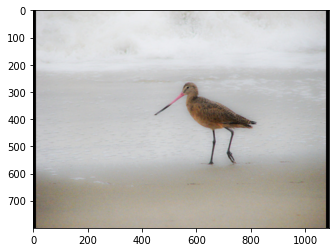

In [4]:
num_i = 8
a,b,c, d = generate_targets(img_data[:num_i], bbox_data[:num_i], label_data[:num_i], mask_data_per_img[:num_i])

In [5]:
def visulaize_targets(cat_targets, mask_targets, active_masks, images):
  for image_id in range(len(images)):
    fig, arr = plt.subplots(1, 5, sharey=True, sharex=True)
    fig.set_size_inches(12*2, 8*2)

    img_pyramid_cat_targets=cat_targets[image_id]
    img_pyramid_mask_targets=mask_targets[image_id]
    img_pyramid_active_masks=active_masks[image_id]
    img_to_show = images[image_id].cpu().detach().numpy().transpose(1,2,0)/255
    # print(img_to_show.shape)
    mask_to_show = np.zeros_like(img_to_show, dtype = np.float64) #lucky since there are only 3 objects


    for pyramid_id in range(5):
      print("The pyramid level is",pyramid_id)
      # plt.imshow(img_imp.cpu().detach().numpy().transpose(1,2,0))
      # plt.show()
      
      curr_active_mask=img_pyramid_active_masks[pyramid_id] 
      curr_cat_targets=img_pyramid_cat_targets[pyramid_id]
      curr_pyramid_mask=img_pyramid_mask_targets[pyramid_id]

      obj1_ind=torch.where(curr_cat_targets==1)
      obj2_ind=torch.where(curr_cat_targets==2)
      obj3_ind=torch.where(curr_cat_targets==3)

      if(obj1_ind[0].shape[0]>0):
        mask_to_vis=(torch.sum(curr_pyramid_mask[obj1_ind[0]*num_grids[pyramid_id]+obj1_ind[1]],axis=0)).unsqueeze(dim=0).unsqueeze(dim=0)
        # print(mask_to_vis.shape)
        mask_to_vis=torch.clip(mask_to_vis,0,1)
        interpolated_mask=F.interpolate(mask_to_vis,size=(800,1088),mode='nearest')
        # print(interpolated_mask.shape)
        # mask_to_show[:,:,0] = np.add(mask_to_show[:, :, 0], interpolated_mask[0][0])
        mask_to_show[:,:,2] = 255*interpolated_mask[0][0]
        # plt.imshow(interpolted_mask[0][0])
        # plt.show()
      if(obj2_ind[0].shape[0]>0):
        mask_to_vis=(torch.sum(curr_pyramid_mask[obj2_ind[0]*num_grids[pyramid_id]+obj2_ind[1]],axis=0)).unsqueeze(dim=0).unsqueeze(dim=0)
        mask_to_vis=torch.clip(mask_to_vis,0,1)
        interpolated_mask=F.interpolate(mask_to_vis,size=(800,1088),mode='nearest')
        # plt.imshow(interpolated_mask[0][0]*0.5)
        # plt.show()
        mask_to_show[:,:,1] = 255*interpolated_mask[0][0]

      if(obj3_ind[0].shape[0]>0):
        mask_to_vis=(torch.sum(curr_pyramid_mask[obj3_ind[0]*num_grids[pyramid_id]+obj3_ind[1]],axis=0)).unsqueeze(dim=0).unsqueeze(dim=0)
        mask_to_vis=torch.clip(mask_to_vis,0,1)
        interpolated_mask=F.interpolate(mask_to_vis,size=(800,1088),mode='nearest')
        mask_to_show[:,:,0] =  255*interpolated_mask[0][0]
        # plt.imshow(interpolated_mask[0][0]*0.5)
        # plt.show()
      mask_vis = np.clip(0.5*mask_to_show+img_to_show,0,1)
      arr[pyramid_id].imshow(mask_vis)
      arr[pyramid_id].set_title('Level ' + str(pyramid_id+1))
    plt.show()


The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


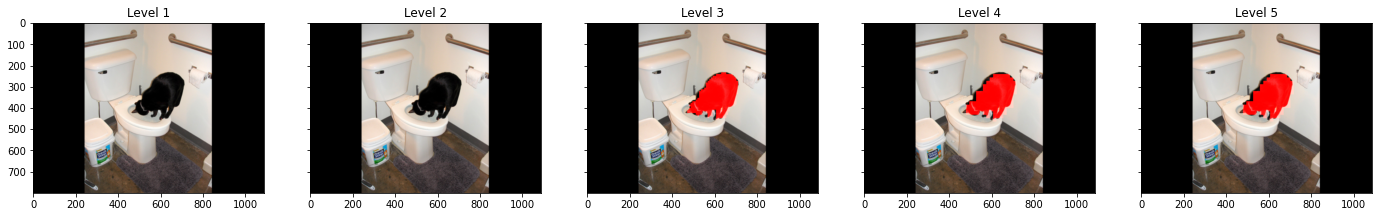

The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


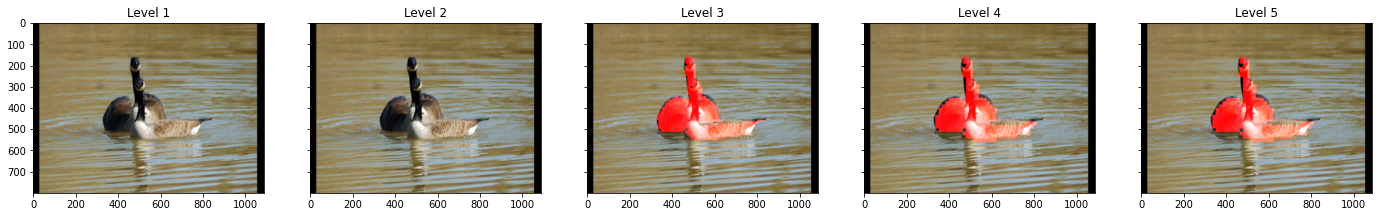

The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


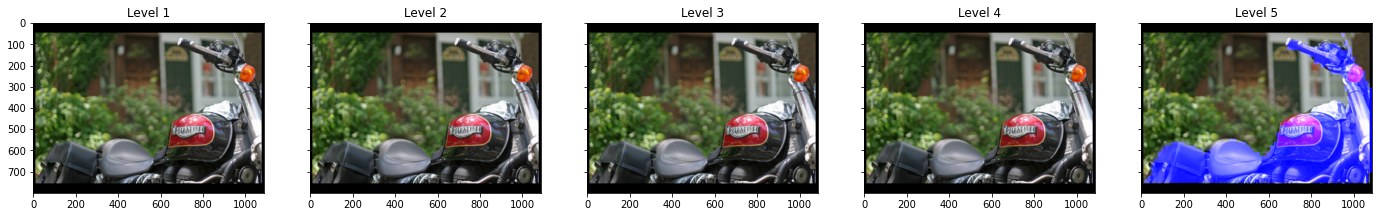

The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


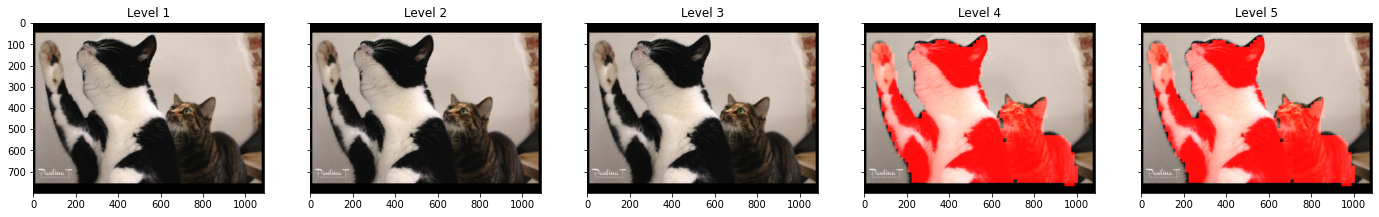

The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


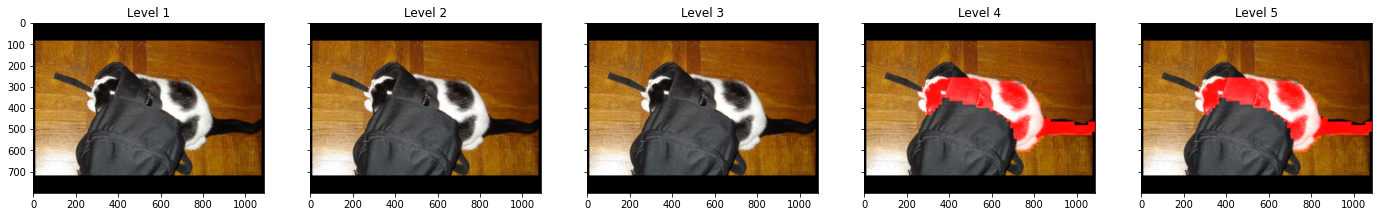

The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


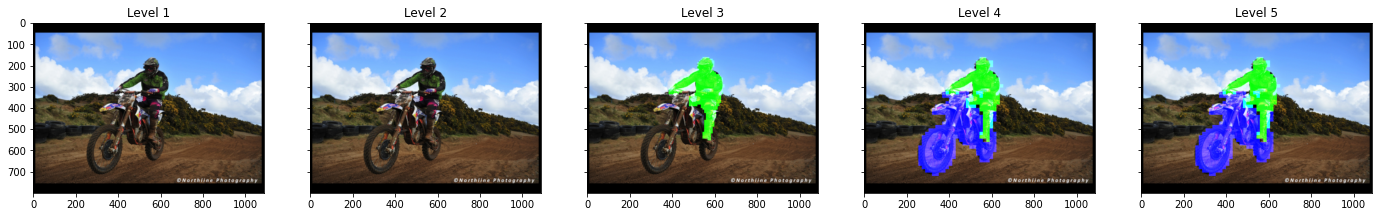

The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


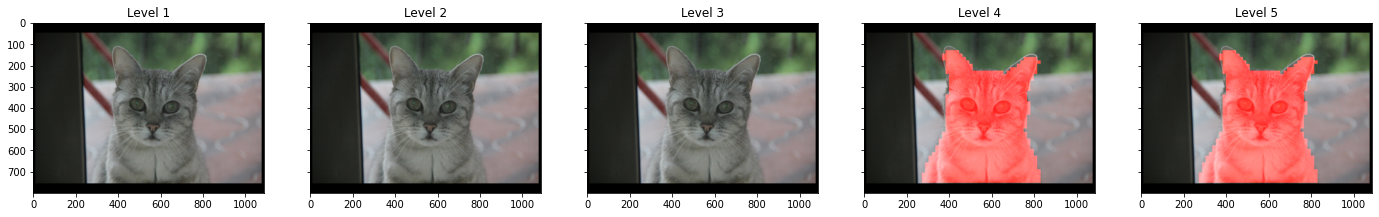

The pyramid level is 0
The pyramid level is 1
The pyramid level is 2
The pyramid level is 3
The pyramid level is 4


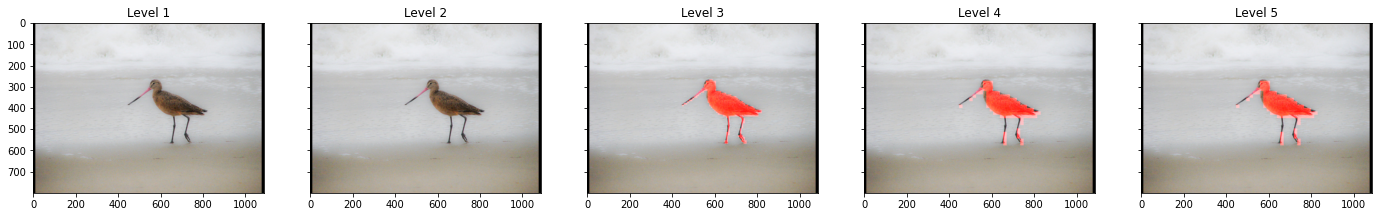

In [6]:
visulaize_targets(a[:num_i], b[:num_i], c[:num_i],d[:num_i])

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.
 
#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Callable, Dict, List, Optional, Tuple
from torch import Tensor
from copy import deepcopy

In [13]:
class network(nn.Module):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone.to(device)

        self.strides =  [8, 8, 16, 32, 32]
        self.num_grids = [40, 36, 24, 16, 12]
        self.scale_ranges = [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)]
        self.epsilon= 0.2

        self.cat = nn.Sequential(
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            #convout
            nn.Conv2d(in_channels = 256,out_channels=3, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid()
        )

        self.mask = nn.Sequential(
            nn.Conv2d(in_channels = 258,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(), 
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU()
        )


        self.headout = nn.ModuleList([nn.Conv2d(in_channels =256, out_channels= i*i, kernel_size=1, stride=1, padding=0, bias=True) for i in self.num_grids])


    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images, eval=False):
        # you can modify this if you want to train the backbone
        
        if(not eval):
          feature_pyramid = [v.detach() for v in self.backbone(images).values()]
        if(eval):
          print("because of Batchnorm")
          self.backbone.eval()
          feature_pyramid = [v.detach() for v in self.backbone(images).values()]
        # feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64] 
        
        
        cat_head_out = []
        mask_head_out = []
        num_imgs = len(images)
        h = 800.0
        w = 1088.0
        m = nn.Sigmoid()
        for i, pyr_img in enumerate(feature_pyramid):
          cat_reshape = F.interpolate(pyr_img ,size= (self.num_grids[i], self.num_grids[i]), mode= 'bilinear')
          #pass it to the cat head now
          cat_out = self.cat(cat_reshape)
          cat_head_out.append(cat_out)

          #mask interpolate first
          mask_new = F.interpolate(pyr_img, size=(int(h/self.strides[i]), int(w/self.strides[i])), mode= 'bilinear')
          #add 2 layers of normalised coordinates to it
          some_arr_row = torch.tile(torch.linspace(-1,1,int(h/self.strides[i])).to(device), dims=(int(w/self.strides[i]), 1)).T          
          some_arr_row = some_arr_row.unsqueeze(dim=0).repeat(num_imgs, 1, 1, 1)
          some_arr_col = torch.tile(torch.linspace(-1,1,int(w/self.strides[i])).to(device), dims=(int(h/self.strides[i]), 1))
          some_arr_col = some_arr_col.unsqueeze(dim=0).repeat(num_imgs, 1, 1, 1)
          # print(some_arr_row.shape)       
          mask_new = torch.cat((mask_new, some_arr_row), dim=1)
          mask_new = torch.cat((mask_new, some_arr_col), dim=1) 
          #pass mask now
          mask_out = self.mask(mask_new)
          # mask_out = m(self.headout[i](mask_out))
          # print(mask_out.shape)

          mask_out = F.interpolate(self.headout[i](mask_out), size=(int(2*mask_out.shape[-2]), int(2*mask_out.shape[-1]) ),mode='bilinear')
          # print(mask_out.shape)

          mask_head_out.append(mask_out)

        return cat_head_out, mask_head_out

    def generate_targets(self, images, bounding_boxes, labels, masks):

      # i, m,b,l = dataset(img_data, deepcopy(label_data), mask_data_per_img, deepcopy(bbox_data))[1]
      # print(b)
      # plt.imshow(i.cpu().detach().numpy().transpose(1,2,0))

      num_imgs = len(images)
      # print(num_imgs)
      cat_tgts = [[] for kk in range(num_imgs)]
      mask_tgts = [[] for kk in range(num_imgs)]
      active_tgts = [[] for kk in range(num_imgs)]
      img_appended = []
      for n in range(num_imgs): #for each image
        pyr_appended_cat = []
        pyr_appended_mask = []
        pyr_appended_active = []
        # from copy import deepcopy
        # print(masks[n])
        # img_imp,mask_imp, bbox_imp , label_imp= dataset(images, deepcopy(labels), masks, deepcopy(bounding_boxes))[n]
        img_imp,mask_imp, bbox_imp , label_imp= images[n], masks[n], bounding_boxes[n], labels[n] 
        # print(bbox_imp)
        # plt.imshow(img_imp.cpu().detach().numpy().transpose(1,2,0))
        bbox_imp = torch.from_numpy(bbox_imp)
        label_imp = torch.from_numpy(label_imp)
        area = torch.sqrt((bbox_imp[:,2] - bbox_imp[:,0])*(bbox_imp[:,3] - bbox_imp[:,1]))
        # print(area)
        img_appended.append(img_imp)
        #scaling bbox to find the central box!!!
        w_sbox = (bbox_imp[:,2] - bbox_imp[:,0])*self.epsilon
        h_sbox = (bbox_imp[:,3] - bbox_imp[:,1])*self.epsilon
        c_x = (bbox_imp[:,2] + bbox_imp[:,0])/2
        c_y = (bbox_imp[:,3] + bbox_imp[:,1])/2
        new_upedges_x = c_x + w_sbox/2 #these will be used to check the grids for the object detection
        new_lowedges_x = c_x - w_sbox/2
        new_upedges_y = c_y + h_sbox/2
        new_lowedges_y = c_y - h_sbox/2
        h = 800.0
        w = 1088.0

        #now going for the pyramid output
        for j in range(5):
          #checking to see if the area is under the scale range or not
          cat_branch = torch.zeros((self.num_grids[j], self.num_grids[j])) #4 channels for 4 outputs
          mask_branch = torch.zeros((self.num_grids[j]*self.num_grids[j], int(2*h/self.strides[j]), int(2*w/self.strides[j])))
          active_branch = torch.zeros((self.num_grids[j]*self.num_grids[j]))
          scale_py = self.scale_ranges[j]
          pass_id = torch.where(torch.logical_and(area>scale_py[0] , area<scale_py[1]))[0] #first check
          # print("The pyramid is",j)
          # print("assigned bboxes are",pass_id)
          
          for match_id, match in enumerate(pass_id):
            #first find the edges of the scaled bbox and do category branch stuff
            #first getting the updated corener in the pyramid wala grid cell
            ud_upcor_x = ((new_upedges_x[match]/w)*self.num_grids[j]).int()
            ud_lowcor_x = ((new_lowedges_x[match]/w)*self.num_grids[j]).int() 
            ud_upcor_y =  ((new_upedges_y[match]/h)*self.num_grids[j]).int()
            ud_lowcor_y = ((new_lowedges_y[match]/h)*self.num_grids[j]).int()
            lb = label_imp[match]
            mk = mask_imp[match]
            # print(ud_upcor_x, ud_lowcor_x, ud_upcor_y, ud_lowcor_y)

            #we just found the cells that are responsible for prediction. Now all cells in between edges are that label.

            row, col = torch.meshgrid(torch.arange(ud_lowcor_x, ud_upcor_x+1, dtype=int), torch.arange(ud_lowcor_y, ud_upcor_y+1,dtype=int) , indexing='ij')
            # print(ud_lowcor_x, ud_upcor_x, ud_lowcor_y, ud_upcor_y)
            cat_branch[row, col] =lb.float()
            #extrapolate masks to this level of py
            ex_mk = F.interpolate(mk.unsqueeze(dim=0).unsqueeze(dim=0).float(), size=(int(2*h/self.strides[j]), int(2*w/self.strides[j])), mode='nearest')

            #each row is 40 elements (eg for 1st py) hence 2nd is 40*2.... so row*40+col

            mask_branch[row.flatten()*self.num_grids[j] + col.flatten()] = ex_mk[0][0] #beacuse size is [1,1, ...]
            active_branch[row.flatten()*self.num_grids[j] + col.flatten()] = 1 #beacuse size is [1,1, ...]
          
          pyr_appended_cat.append(cat_branch)
          pyr_appended_mask.append(mask_branch) 
          pyr_appended_active.append(active_branch)

        cat_tgts[n] = pyr_appended_cat
        mask_tgts[n] = pyr_appended_mask
        active_tgts[n] = pyr_appended_active

      return cat_tgts, mask_tgts, active_tgts

In [14]:
def collate_fn(batch):
    images,  bounding_boxes, masks, labels = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes
my_dataloader=torch.utils.data.DataLoader(my_dataset,batch_size=4,collate_fn=collate_fn)
# t,v = torch.utils.data.random_split(my_dataset, [3, 7], generator=torch.Generator().manual_seed(42))  
my_dataloader_val=torch.utils.data.DataLoader(val_dataset,batch_size=4,collate_fn=collate_fn, shuffle=True)

In [ ]:
#     mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
#     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
#     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)

In [ ]:
def mask_loss(mask_targets,mask_predictions,active_masks):
  dice_loss=0.0
  for image_id in range(len(mask_targets)):
    for pyramid_id in range(5):
      active_masks_pyramid = active_masks[image_id][pyramid_id]
      N_pos = torch.sum(active_masks_pyramid!=0)
      N_pos_2 = torch.sum(active_masks_pyramid)
      if(N_pos.cpu().item()==0):
        continue
      
      mask_present=active_masks_pyramid!=0

      #these are the places in the S*S drawer where the mask images are present
      #found and these get taken for dice calculation eg. gt tells us that 4 images of a certain py level are there. Take these from the preds
      # and then compare them to gt
      mask_pred_target =  mask_predictions[pyramid_id][image_id,mask_present,:,:].cpu()
      # print(mask_pred_target.shape)
      
      mask_grnd_target = mask_targets[image_id][pyramid_id][mask_present,:,:] 
      # print(mask_grnd_target.shape)


      
      denominator = torch.sum((mask_pred_target*mask_pred_target + mask_grnd_target*mask_grnd_target),dim=(1,2))
     
     
      
      numerator = torch.sum((2*mask_pred_target*mask_grnd_target),dim=(1,2))
      dice_target = numerator/(denominator+1e-6)

      dice_loss_level = (1/N_pos.cpu())*(1 - dice_target)
      dice_loss+=torch.sum(dice_loss_level)
  
  return dice_loss/len(mask_targets)
         

In [ ]:
# category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
# category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
def category_focal_loss(category_targets,category_predictions):
  
  gamma=2
  alpha=0.25

  num_grids=[40, 36, 24, 16, 12]
  ## extracting fpn level then would parallise over batch size
  final_loss=0.0
  for pyramid_id in range(5):
    focal_loss=0.0
    #get all images of batch for a particular pyr level and stack them
    final_pyramid_target_list=[category_targets[image][pyramid_id]   for image in range(len(category_targets))]
    final_pyramid_target = torch.stack(final_pyramid_target_list,dim=0)


    category_pred_pyramid=category_predictions[pyramid_id].cpu()
    category_gt_pyramid=final_pyramid_target.type(torch.LongTensor)


    #prepare masks from gt to compare
    bool_mask_1 = (category_gt_pyramid==1).float()
    bool_mask_2 = (category_gt_pyramid==2).float()
    bool_mask_3 = (category_gt_pyramid==3).float()
    epsilon=1e-6
    #for each class, check places where it is actually supposed to be note that cat_pred has 3 channels for classes so category_pred_pyramid[:,0,:,:]
    #is first class
    focal_loss+= torch.sum(bool_mask_1*alpha*torch.pow(1-category_pred_pyramid[:,0,:,:],gamma)*torch.log(category_pred_pyramid[:,0,:,:]+epsilon))
    focal_loss += torch.sum((1-bool_mask_1)*(1-alpha)*torch.pow(category_pred_pyramid[:,0,:,:],gamma)*torch.log(1-category_pred_pyramid[:,0,:,:]+epsilon))

    focal_loss+= torch.sum(bool_mask_2*alpha*torch.pow(1-category_pred_pyramid[:,1,:,:],gamma)*torch.log(category_pred_pyramid[:,1,:,:]+epsilon))
    
    focal_loss += torch.sum((1-bool_mask_2)*(1-alpha)*torch.pow(category_pred_pyramid[:,1,:,:],gamma)*torch.log(1-category_pred_pyramid[:,1,:,:]+epsilon))
    
    focal_loss+= torch.sum(bool_mask_3*alpha*torch.pow(1-category_pred_pyramid[:,2,:,:],gamma)*torch.log(category_pred_pyramid[:,2,:,:]+epsilon))
    
    focal_loss += torch.sum((1-bool_mask_3)*(1-alpha)*torch.pow(category_pred_pyramid[:,2,:,:],gamma)*torch.log(1-category_pred_pyramid[:,2,:,:]+epsilon))


    final_loss+=(focal_loss/(3*category_gt_pyramid.shape[1]*category_gt_pyramid.shape[2]*len(category_targets)))
    

  return -final_loss


In [ ]:
# solo_life=SOLO_Model().to(device)
solo_life=network().to(device)
import torch.optim as optim
optimizer = optim.SGD(solo_life.parameters(), lr=0.001, momentum=0.9)
total_loss_list=[]
dice_loss_list=[]
focal_loss_list=[]
total_loss_list_val=[]
dice_loss_list_val=[]
focal_loss_list_val=[]

for epoch in range(40):
  total_loss=0
  dice_loss=0
  focal_loss=0

  solo_life.train()
  for idx, batch in enumerate(my_dataloader):

    category_preds,mask_preds=solo_life(batch[0].float().to(device),eval=False)
    
    nan_list_category=[torch.any(torch.isnan(category_pred)) for category_pred in category_preds]
    nan_list_mask=[torch.any(torch.isnan(mask_pred)) for mask_pred in mask_preds]

    if True in nan_list_category:
      print("category has nan")
      print(nan_list_category)
      import sys
      sys.exit()
    if True in nan_list_mask:
      print("mask has nan")
      print(nan_list_mask)
      import sys
      sys.exit()

    category_targets,mask_targets,active_masks=solo_life.generate_targets(batch[0].float(),batch[3],batch[1],batch[2])
    focal_loss_per_batch=category_focal_loss(category_targets,category_preds)
    mask_loss_per_batch=mask_loss(mask_targets,mask_preds,active_masks)
    total_loss_per_batch = focal_loss_per_batch+3*mask_loss_per_batch
    # del category_preds
    # del mask_preds
    # del category_targets
    # del mask_targets
    # del active_masks
    # torch.cuda.empty_cache()

    
    total_loss+=total_loss_per_batch
    dice_loss+=mask_loss_per_batch
    focal_loss+=focal_loss_per_batch

    optimizer.zero_grad()
    total_loss_per_batch.backward()
    optimizer.step()

    del category_preds
    del mask_preds
    del category_targets
    del mask_targets
    del active_masks
    torch.cuda.empty_cache()
  


  # GPUtil.showUtilization()

  total_loss=total_loss/(idx+1)
  total_loss_list.append(total_loss.item())
  dice_loss=dice_loss/(idx+1)
  dice_loss_list.append(dice_loss.item())
  focal_loss=focal_loss/(idx+1)
  focal_loss_list.append(focal_loss.item())

  print("epoch",epoch)
  print("Total loss after epoch",total_loss.item())
  print("Dice loss after epoch",dice_loss.item())
  print("Focal loss after epoch",focal_loss.item())

  #doing validation 
  total_loss_val=0
  dice_loss_val=0
  focal_loss_val=0
  solo_life.eval()
  for idx_val, val_batch in enumerate(my_dataloader_val):
    category_pred_val,mask_pred_val=solo_life(val_batch[0].float().to(device),eval=True)
    category_targets_val,mask_targets_val,active_masks_val=solo_life.generate_targets(val_batch[0].float(),val_batch[3],val_batch[1],val_batch[2])
    focal_loss_per_batch_val=category_focal_loss(category_targets_val,category_pred_val)
    mask_loss_per_batch_val=mask_loss(mask_targets_val,mask_pred_val,active_masks_val)
    total_loss_per_batch_val = focal_loss_per_batch_val+3*mask_loss_per_batch_val

    total_loss_val+=total_loss_per_batch_val
    dice_loss_val+=mask_loss_per_batch_val
    focal_loss_val+=focal_loss_per_batch_val

    del category_pred_val
    del mask_pred_val
    del category_targets_val
    del mask_targets_val
    del active_masks_val
    torch.cuda.empty_cache()
  
  total_loss_val=total_loss_val/(idx_val+1)
  dice_loss_val=dice_loss_val/(idx_val+1)
  focal_loss_val=focal_loss_val/(idx_val+1)
  total_loss_list_val.append(total_loss_val.item())
  dice_loss_list_val.append(dice_loss_val.item())
  focal_loss_list_val.append(focal_loss_val.item())
  print("Total val loss after epoch",total_loss_val.item())
  print("Dice val loss after epoch",dice_loss_val.item())
  print("Focal val loss after epoch",focal_loss_val.item())


    # pass
  
  if((epoch+1)%10==0):
   
    path_folder="/content/drive/MyDrive/CIS680/hw3/models/experiment/"
    import os
    if(not os.path.exists(path_folder)):
      os.mkdir(path_folder)
      print("making the directory",path_folder)
    
    print("checkpointing model")
    path=path_folder+"model_checkpoint_"+str(epoch+1)+".pth"
    torch.save({
                'model_state_dict': solo_life.state_dict(),
                }, path)

   
       

print('Finished Training')

epoch 0
Total loss after epoch 5.11472749710083
Dice loss after epoch 1.5907799005508423
Focal loss after epoch 0.34238770604133606
because of Batchnorm
because of Batchnorm
because of Batchnorm
Total val loss after epoch 4.147250652313232
Dice val loss after epoch 1.3585618734359741
Focal val loss after epoch 0.07156488299369812
epoch 1
Total loss after epoch 3.820915937423706
Dice loss after epoch 1.2557940483093262
Focal loss after epoch 0.05353355407714844
because of Batchnorm
because of Batchnorm
because of Batchnorm
Total val loss after epoch 3.231773614883423
Dice val loss after epoch 1.0644947290420532
Focal val loss after epoch 0.03828961402177811
epoch 2
Total loss after epoch 3.42874813079834
Dice loss after epoch 1.1310911178588867
Focal loss after epoch 0.03547484800219536
because of Batchnorm
because of Batchnorm
because of Batchnorm
Total val loss after epoch 3.1964426040649414
Dice val loss after epoch 1.0534025430679321
Focal val loss after epoch 0.0362345427274704
epo

In [ ]:
def collate_fn(batch):
    images,  bounding_boxes, masks, labels = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes
my_dataloader=torch.utils.data.DataLoader(my_dataset,batch_size=4,collate_fn=collate_fn)

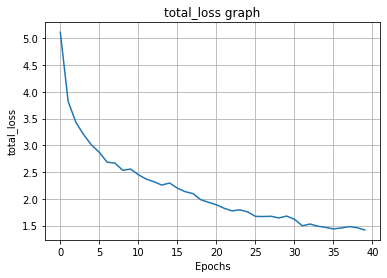

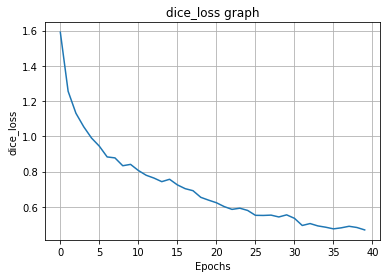

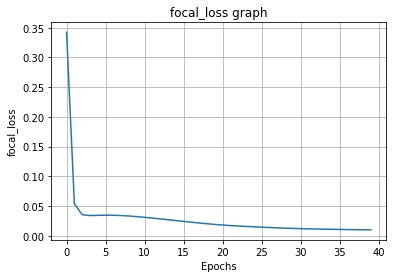

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_loss_list)
plt.xlabel('Epochs')
plt.ylabel('total_loss')
plt.title('total_loss graph')
plt.grid(True)
plt.show()
plt.plot(dice_loss_list)
plt.xlabel('Epochs')
plt.ylabel('dice_loss')
plt.title('dice_loss graph')
plt.grid(True)
plt.show()
plt.plot(focal_loss_list)
plt.xlabel('Epochs')
plt.ylabel('focal_loss')
plt.title('focal_loss graph')
plt.grid(True)
plt.show()

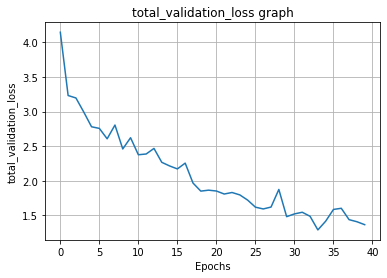

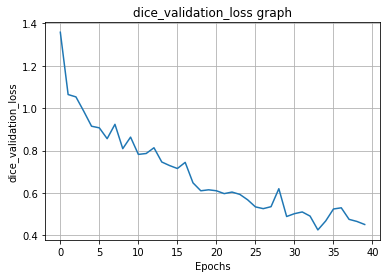

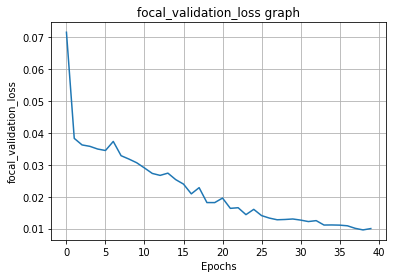

In [ ]:
plt.plot(total_loss_list_val)
plt.xlabel('Epochs')
plt.ylabel('total_validation_loss')
plt.title('total_validation_loss graph')
plt.grid(True)
plt.show()
plt.plot(dice_loss_list_val)
plt.xlabel('Epochs')
plt.ylabel('dice_validation_loss')
plt.title('dice_validation_loss graph')
plt.grid(True)
plt.show()
plt.plot(focal_loss_list_val)
plt.xlabel('Epochs')
plt.ylabel('focal_validation_loss')
plt.title('focal_validation_loss graph')
plt.grid(True)
plt.show()

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [15]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection +1e-6
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

In [29]:
my_dataloader=torch.utils.data.DataLoader(my_dataset,batch_size=5,collate_fn=collate_fn)


In [30]:
solo_life.eval()
batch = next(iter(my_dataloader))
category_preds,mask_preds=solo_life(batch[0].float().to(device),eval=True)


because of Batchnorm


##uncomment for loading image from a checkpoint

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

solo_life=network().to(device)
solo_life.load_state_dict(torch.load("/content/drive/MyDrive/CIS680/hw3/models/experiment/model_checkpoint_40.pth")['model_state_dict'])
solo_life.eval()


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

network(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps

In [35]:
mask_img_list=[]
pred_img_classes_list=[]
scores_img_list=[]

for each_img in range(5):
  mask_list=[]
  pred_classes_list=[]
  scores_list=[]
  # print("Information about image number of batch",each_img)
  for pyramid_id in range(5):
    # print(category_preds[pyramid_id][each_img].detach().cpu().unsqueeze(dim=0).shape)
    pyramid_cat_prediction=points_nms(category_preds[pyramid_id][each_img].detach().cpu().unsqueeze(dim=0)).squeeze(dim=0) ## batch_size*num_classes-1*S*S
    # import sys

    flatten_pyramid_cat_prediction=pyramid_cat_prediction.flatten(start_dim=1,end_dim=-1)
    conf_max, pred_classes =torch.max(flatten_pyramid_cat_prediction,dim=0)
 
    ## category thresh
    indices_to_keep = torch.nonzero(conf_max > 0.2 )[:,0]
  
    H=800
    W=1088
    
    ## mask threshold
    # print(mask_preds[pyramid_id][each_img].shape)

    curr_mask=torch.where(mask_preds[pyramid_id][each_img]>=0.5,1,0)
    mask_reshaped=F.interpolate(curr_mask.unsqueeze(dim=0).detach().cpu().float(),size=(int(H/4),int(W/4)),mode='nearest')

    masks_to_keep=mask_reshaped[0][indices_to_keep]
    pred_classes=pred_classes[indices_to_keep]
    filtered_scores=conf_max[indices_to_keep]

    mask_list.append(masks_to_keep)
    pred_classes_list.append(pred_classes)
    scores_list.append(filtered_scores)


  masks_all_fpn=torch.cat(mask_list)
  pred_classes_all_fpn=torch.cat(pred_classes_list)
  scores_list_all_fpn=torch.cat(scores_list)


  sorted_indices=torch.argsort(scores_list_all_fpn,descending=True)
  scores_list_all_fpn=scores_list_all_fpn[sorted_indices]
  pred_classes_all_fpn=pred_classes_all_fpn[sorted_indices]
  masks_sorted_all_fpn=masks_all_fpn[sorted_indices]

  mask_img_list.append(masks_sorted_all_fpn)
  pred_img_classes_list.append(pred_classes_all_fpn)
  scores_img_list.append(scores_list_all_fpn)


  IOU_scores=MatrixNMS(masks_sorted_all_fpn.cpu(),scores_list_all_fpn)

  # print("IOU scores are",IOU_scores)
  # print("sorted confidences are", scores_list_all_fpn)
  # print("sorted prediction labels are", pred_classes_all_fpn)

  final_mask=masks_sorted_all_fpn[IOU_scores>0.5]
  final_pred_classes=pred_classes_all_fpn[IOU_scores>0.5]
  final_conf=scores_list_all_fpn[IOU_scores>0.5]






    
    
 


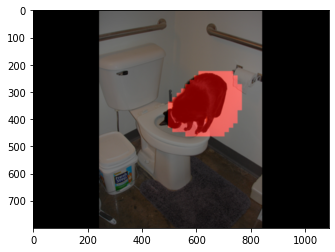

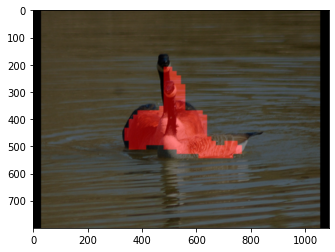

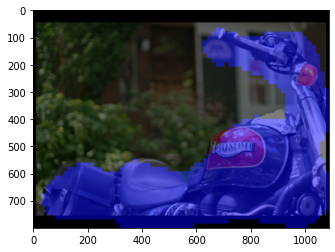

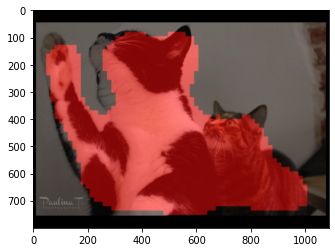

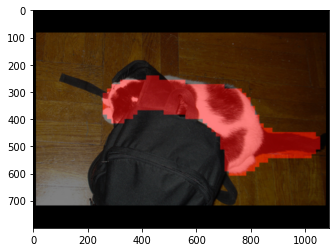

In [45]:
import matplotlib.pyplot as plt
##change this


image_id_of_batch=4
curr_pred_masks=mask_img_list[image_id_of_batch]
curr_pred_class = pred_img_classes_list[image_id_of_batch]
# print(curr_pred_class)


for id, mask in enumerate(curr_pred_masks):
  fig = plt.figure()
  img1 = my_dataset_vis[image_id_of_batch][0].numpy().transpose(1,2,0)
  plt.imshow(img1)
  mask_vis = np.zeros_like(img1, dtype=np.float64)
  # print(img1.shape)
  curr_mask = F.interpolate(mask.unsqueeze(dim=0).unsqueeze(dim=0),size=(800,1088),mode='bilinear').cpu().float().numpy()[0][0]
  if(curr_pred_class[id]==0): #animal
    mask_vis[:,:,0] = curr_mask
  if(curr_pred_class[id]==1): #person
    mask_vis[:,:,1] = curr_mask
  if(curr_pred_class[id]==2): #animal
    mask_vis[:,:,2] = curr_mask
  # print(curr_mask.shape)
  plt.imshow(mask_vis,alpha=0.5)
  # plt.imshow(mask.detach().cpu().float().numpy())
  plt.show()

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

There will likely be a performance benchmark for this project - more details to be announced.